In [170]:
import os
import glob
import re

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv

"""
LOAD CONFIGURATIONS FROM .env FILE
"""
load_dotenv()

TRAIN_DATASET_CLASSIC_PATH = f'{os.getcwd()}/{os.getenv("TRAIN_DATASET_CLASSIC_PATH")}'
OUTPUT_PATH = f'{os.getcwd()}{os.getenv("OUTPUT_PATH")}'
THRESHOLD_DETECTION_GAP = float(os.getenv('THRESHOLD_DETECTION_GAP', 0.8))

In [171]:
templates_config = {
    'orange': glob.glob(os.path.join('./datasets/bonus_templates', 'orange_*.png')),
    'blue': glob.glob(os.path.join('./datasets/bonus_templates', 'blue_*.png')),
    'yellow': glob.glob(os.path.join('./datasets/bonus_templates', 'yellow_*.png')),
    'green': glob.glob(os.path.join('./datasets/bonus_templates', 'green*.png')),
    'white': glob.glob(os.path.join('./datasets/bonus_templates', 'white_*.png')),
    'red': glob.glob(os.path.join('./datasets/bonus_templates', 'red_*.png')),
}

def shape_name_to_code(color_name, pattern_name):
    code = ""
    match_shape_name = re.search(r'.*\_(.*)\.png', pattern_name)
    if match_shape_name is None:
        raise Exception("Cannot find shape name in the name of the template.")
    
    shape_name = match_shape_name.group(1)
    if shape_name == "circle":
        code += "1"
    elif shape_name == "clover":
        code += "2"
    elif shape_name == "diamond":
        code += "3"
    elif shape_name == "square":
        code += "4"
    elif shape_name == "star":
        code += "5"
    elif shape_name == "8-star":
        code += "6"
    else:
        code += "?"
        
    if color_name == "red":
        code += "R"
    elif color_name == "orange":
        code += "O"
    elif color_name == "blue":
        code += "B"
    elif color_name == "yellow":
        code += "Y"
    elif color_name == "green":
        code += "G"
    elif color_name == "white":
        code += "W"
    else:
        code += "?"
    return code

THRESHOLD_DETECTION_PIECE = 0.85
def extract_pieces_from_image(image):
    copy_image = image.copy()
    detections = []
    for color_name, template_paths in templates_config.items():
        for template_path in template_paths:
            template = cv.imread(template_path, cv.IMREAD_COLOR_BGR|cv.IMREAD_IGNORE_ORIENTATION)
            template = cv.resize(template, None, fx=1.5, fy=1.5, interpolation=cv.INTER_LINEAR)
            template = cv.medianBlur(template, 3)
            template = cv.morphologyEx(template, cv.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=1)
            h, w, _ = template.shape
            
            res = cv.matchTemplate(image, template, cv.TM_CCOEFF_NORMED)
            loc = np.where(res >= THRESHOLD_DETECTION_PIECE)
            
            boxes = []
            scores = []
            
            for pt in zip(*loc[::-1]):
                box = [pt[0], pt[1], w, h]  # x, y, width, height
                boxes.append(box)
                scores.append(res[pt[1], pt[0]])
            
            indices = cv.dnn.NMSBoxes(boxes, scores, score_threshold=THRESHOLD_DETECTION_PIECE, nms_threshold=0.3)
            for i in indices:
                i = i[0] if isinstance(i, (tuple, list, np.ndarray)) else i
                x, y, bw, bh = boxes[i]
                detections.append((shape_name_to_code(color_name, template_path), boxes[i], scores[i]))
                cv.rectangle(copy_image, (x, y), (x + bw, y + bh), (255, 255, 0), -1)
    return detections

def set_position_to_matrix(n, coord_x, coord_y):
    origin = n // 2
    position_x = origin - coord_y
    position_y = origin + coord_x # column
    return position_x, position_y

def filter_pieces(results):
    d = dict()
    for result in results:
        if (result[1], result[2]) not in d.keys():
            d[result[1], result[2]] = (result[3], result[0])
        else:
            if result[3] > d[(result[1], result[2])][0]:
                d[result[1], result[2]] = (result[3], result[0])
    filtered = []
    for key, value in d.items():
        filtered.append((value[1], key[0], key[1], value[0]))
    return filtered

def extract_position(detections, origin_x, origin_y):
    tile_size = 240; rel_positions = []
    for code, (x, y, w, h), score in detections:
        gx = round((x - origin_x) / tile_size)
        gy = round((y - origin_y) / tile_size)
        rel_positions.append((code, gx, -gy, score))
    return rel_positions

def extract_results_from_pieces(results, result_pieces):
    results_selected = []
    for result_piece in result_pieces:
        for result in results:
            if result[0] == result_piece[0]:
                results_selected.append(result)
                break
    return results_selected

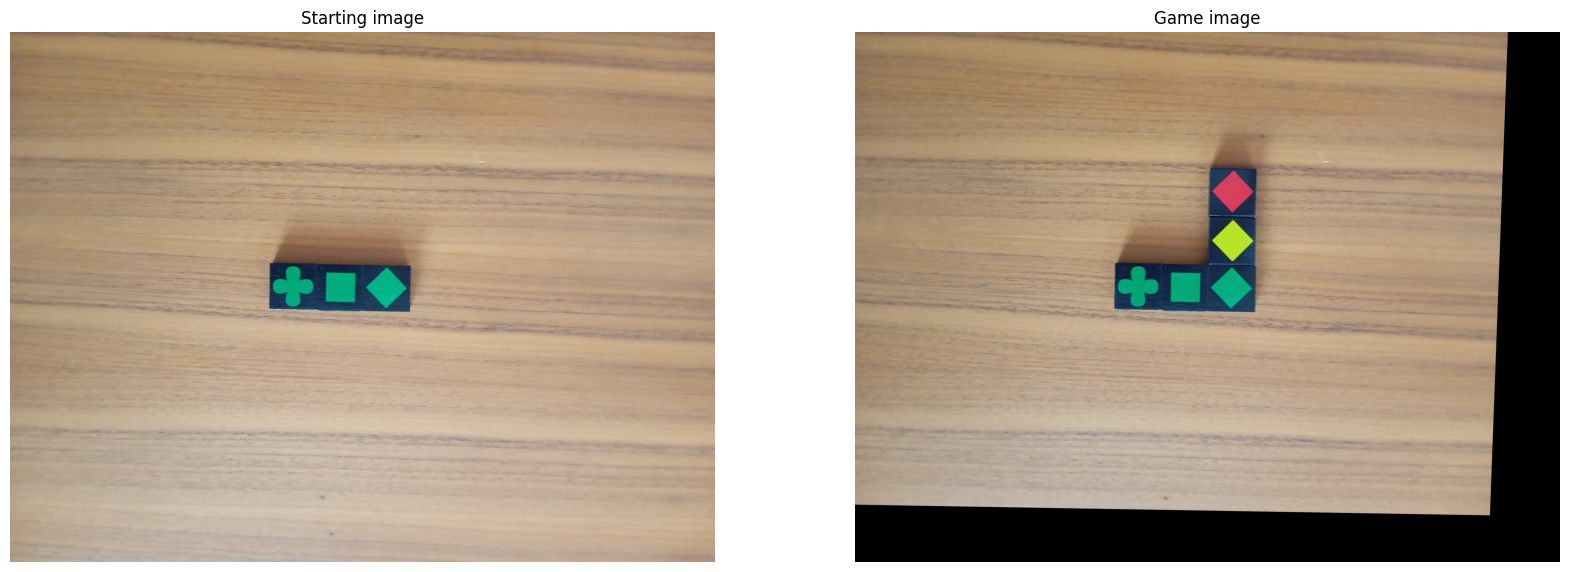

In [173]:
def preprocess(img):
    # median blur + open + normalize to [0,255] gray
    blurred = cv.medianBlur(img, 3)
    opened  = cv.morphologyEx(blurred, cv.MORPH_OPEN, np.ones((3,3), np.uint8))
    gray    = cv.cvtColor(opened, cv.COLOR_BGR2GRAY)
    gray    = cv.normalize(gray, None, 0, 350, cv.NORM_MINMAX).astype(np.uint8)
    return gray

def convert_next_image_using_SIFT(first_image, next_image):
    # preprocess both
    gray1 = preprocess(first_image)
    gray2 = preprocess(next_image)

    # SIFT detect & describe
    sift = cv.SIFT_create()
    kps1, desc1 = sift.detectAndCompute(gray1, None)
    kps2, desc2 = sift.detectAndCompute(gray2, None)

    # k-NN match + Lowe's ratio test
    bf = cv.BFMatcher()
    knn_matches = bf.knnMatch(desc1, desc2, k=2)
    good_matches = [m for m,n in knn_matches if m.distance < 0.7 * n.distance]

    if len(good_matches) < 8:
        raise RuntimeError(f"Too few matches ({len(good_matches)})")

    # extract points
    pts1 = np.float32([kps1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    pts2 = np.float32([kps2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # robust homography
    H, mask = cv.findHomography(
        pts2, pts1,
        method=cv.RANSAC,
        ransacReprojThreshold=3.0,
        maxIters=2000,
        confidence=0.995
    )

    # warp
    h, w = first_image.shape[:2]
    warped = cv.warpPerspective(
        next_image, H,
        dsize=(w,h),
        flags=cv.INTER_LINEAR,
        borderMode=cv.BORDER_CONSTANT
    )
    return warped, (kps1, kps2, good_matches, mask)

# Example usage:
n = 216
game_state = [["?"] * n for _ in range(n)]

first_image = cv.imread(f'{TRAIN_DATASET_CLASSIC_PATH}/1_01.jpg')
results = extract_pieces_from_image(first_image)

"""
Compute origin of the cartesian system
"""
sorted_results = sorted(results, key=lambda d: (d[1][1], d[1][0]))
origin_x, origin_y = sorted_results[0][1][0], sorted_results[0][1][1]

"""
Build the initial matrix
"""
result_pieces = extract_position(results, origin_x, origin_y)
result_pieces = filter_pieces(result_pieces)
final_results = extract_results_from_pieces(results, result_pieces)
sorted_result_pieces = sorted(result_pieces, key=lambda d: (d[1], -d[2]))
for i, result_piece in enumerate(result_pieces):
    position = set_position_to_matrix(n, result_piece[1], result_piece[2])
    game_state[position[0]][position[1]] = (result_piece[0], final_results[i])
    
f = open(f'{OUTPUT_PATH}/bonus/1_01.txt', 'w')
for sorted_result_piece in sorted_result_pieces:
    f.write(f"{sorted_result_piece[1]} {sorted_result_piece[2]} {sorted_result_piece[0]}\n")
f.write("0")
f.close()

# compute fucking score

for i in range(2, 21):
    image = cv.imread(f'{TRAIN_DATASET_CLASSIC_PATH}/1_{i:02d}.jpg')
    warp_image, debug = convert_next_image_using_SIFT(first_image, image)
    
    for j in range(len(game_state)):
        for k in range(len(game_state[j])):
            if game_state[j][k] != "?":
                x, y, bw, bh = game_state[j][k][1][1]
                cv.rectangle(warp_image, (x, y), (x+bw, y+bh), (255, 255, 0), -1)
    
    results = extract_pieces_from_image(warp_image)
    result_pieces = extract_position(results, origin_x, origin_y)
    result_pieces = filter_pieces(result_pieces)
    final_results = extract_results_from_pieces(results, result_pieces)
    sorted_result_pieces = sorted(result_pieces, key=lambda d: (d[1], -d[2]))
    for l, result_piece in enumerate(result_pieces):
        position = set_position_to_matrix(n, result_piece[1], result_piece[2])
        game_state[position[0]][position[1]] = (result_piece[0], final_results[l])
    
    f = open(f'{OUTPUT_PATH}/bonus/1_{i:02d}.txt', 'w')
    for sorted_result_piece in sorted_result_pieces:
        f.write(f"{sorted_result_piece[1]} {sorted_result_piece[2]} {sorted_result_piece[0]}\n")
    f.write("0")
    f.close()